In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from dataclasses import dataclass
from typing import Literal, Any
from tabulate import tabulate

In [3]:
@dataclass
class Result:
    train_losses: list[float]
    avg_train_accuracies: list[float]
    test_losses: list[float]
    test_accuracies: np.ndarray
    avg_test_accuracies: list[float]
    test_precision: np.ndarray
    test_recall: np.ndarray
    test_f1score: np.ndarray
    avg_test_precision: float
    avg_test_recall: float
    avg_test_f1score: float

DIFF_METRICS = {
    "Train Accuracy": {
        "key": "avg_train_accuracies",
        "get_value": lambda x: x[-1]*100.0,
    },
    "Test Accuracy": {
        "key": "avg_test_accuracies",
        "get_value": lambda x: x[-1]*100.0,
    },
    "Test Precision": {
        "key": "avg_test_precision",
        "get_value": lambda x: x*100.0,
    },
    "Test Recall": {
        "key": "avg_test_recall",
        "get_value": lambda x: x*100.0,
    },
    "Test F1 Score": {
        "key": "avg_test_f1score",
        "get_value": lambda x: x*100.0,
    }
}

In [4]:
CLASS_NAMES = []
with open("./name_of_the_animals.txt", "r") as file:
    for line in file:
        CLASS_NAMES.append(line.strip())

In [5]:
def print_basic_results(result: Result):
    print(f"Train Loss: {result.train_losses[-1]}")
    print(f"Train Accuracy: {result.avg_train_accuracies[-1] * 100}%\n")
    print(f"Test Loss: {result.test_losses[-1]}")
    print(f"Test Accuracy: {result.avg_test_accuracies[-1] * 100}%\n")
    print(f"Test Precision: {result.avg_test_precision * 100}%")
    print(f"Test Recall: {result.avg_test_recall * 100}%")
    print(f"Test F1 Score: {result.avg_test_f1score * 100}%")

In [6]:
def plot_diff_table(results: dict[str, Result], title: str, metrics: dict[str, dict[str, Any]]) -> None:
    metric_names = list(metrics.keys())
    values = []
    for result_name, result in results.items():
        row_array = [result_name]
        for _, metric in metrics.items():
            value = str(np.round(metric["get_value"](result.__getattribute__(metric["key"])), decimals=4)) + "%"
            row_array.append(value)
        values.append(row_array)
    print(tabulate(values, headers=metric_names, tablefmt="rounded_grid"))

In [7]:
def plot_loss_accuracy(result: Result) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.4)

    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].plot(result.train_losses, label="Train Loss", color="blue")
    ax[0].plot(result.test_losses, label="Test Loss", color="red")
    ax[0].legend()
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].grid(axis="both", linestyle="--", alpha=0.7)

    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].plot(np.array(result.avg_train_accuracies)*100, label="Train Accuracy", color="blue")
    ax[1].plot(np.array(result.avg_test_accuracies)*100, label="Test Accuracy", color="red")
    ax[1].legend()
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].grid(axis="both", linestyle="--", alpha=0.7)

In [17]:
def plot_loss_accuracy_diff(result_left: Result, result_right: Result, left_name: str, right_name: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.4)

    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].plot(result_left.train_losses, label=f"{left_name}Train Loss", color="blue")
    ax[0].plot(result_left.test_losses, label=f"{left_name}Test Loss", color="red")
    ax[0].plot(result_right.train_losses, label=f"{right_name}Train Loss", color="cyan")
    ax[0].plot(result_right.test_losses, label=f"{right_name}Test Loss", color="orange")
    ax[0].legend()
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].grid(axis="both", linestyle="--", alpha=0.7)

    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].plot(np.array(result_left.avg_train_accuracies)*100, label=f"{left_name}Train Accuracy", color="blue")
    ax[1].plot(np.array(result_left.avg_test_accuracies)*100, label=f"{left_name}Test Accuracy", color="red")
    ax[1].plot(np.array(result_right.avg_train_accuracies)*100, label=f"{right_name}Train Accuracy", color="cyan")
    ax[1].plot(np.array(result_right.avg_test_accuracies)*100, label=f"{right_name}Test Accuracy", color="orange")
    ax[1].legend()
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].grid(axis="both", linestyle="--", alpha=0.7)

In [9]:
def plot_improvement_by_class(
    result_left: Result,
    result_right: Result,
    metric: Literal["test_accuracies", "test_precision", "test_recall", "test_f1score"],
    classes: list[str],
    title: str = "Changes by Class",
    multiply_by: float = 1.0,
) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

    diffs = np.array(result_right.__getattribute__(metric) - result_left.__getattribute__(metric))*multiply_by
    sorted_indices = np.argsort(diffs)
    diffs = diffs[sorted_indices]
    classes = np.array(classes)[sorted_indices]

    mask_positive = diffs >= 0
    mask_negative = diffs < 0

    negative = ax.bar(classes[mask_negative], diffs[mask_negative], color="red")
    ax.bar_label(negative, np.round(diffs[mask_negative], decimals=1), label_type="edge", rotation=90)
    
    positive = ax.bar(classes[mask_positive], diffs[mask_positive], color="green")
    ax.bar_label(positive, np.round(diffs[mask_positive], decimals=1), label_type="edge", rotation=90)

    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel(f"Change in {metric.replace('_', ' ').title()}")

    diff_range = max(diffs) - min(diffs)
    ax.set_ylim(bottom=min(diffs) - 0.2*diff_range, top=max(diffs) + 0.2*diff_range)
    ax.axhline(0, color="black", lw=1, ls="-")

In [10]:
def plot_diff_barchart(results: dict[str, Result], title: str, metrics: dict[str, dict[str, Any]]) -> None:
    metric_names = list(metrics.keys())
    x = np.arange(len(metrics))
    total_width = 0.5
    width = total_width / len(results)
    extra_spacing = 0.05*total_width
    offsets = np.linspace((-total_width/2) + (width/2) - extra_spacing, (total_width/2) - (width/2) + extra_spacing, len(results))
    values = {}
    max_value = 0.0
    for result_name, result in results.items():
        for _, metric in metrics.items():
            if result_name not in values:
                values[result_name] = []
            value = metric["get_value"](result.__getattribute__(metric["key"]))
            values[result_name].append(value)
            if value > max_value:
                max_value = value

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    for i, result_name in enumerate(values):
        bars = ax.bar(x + offsets[i], values[result_name], width, label=result_name)
        ax.bar_label(bars, np.round(values[result_name], decimals=1), label_type="edge", rotation=90)

    ax.set_title(title)
    ax.set_xlabel("Metric")
    ax.set_ylabel("Percent (%)")
    ax.set_xticks(x, metric_names)
    ax.legend(ncols=3)
    ax.set_ylim(bottom=0, top=max_value + 0.2*max_value)

In [11]:
def load_result(model_params: dict, with_details: bool = True) -> Result:
    details = f"_{model_params["epochs"]}e_{str(model_params["learning_rate"])[2:]}lr_{str(model_params["weight_decay"])[2:]}wd" if with_details else ""
    with open(f"./results/{model_params["name"]}{details}.pkl", "rb") as f:
        result = pkl.load(f)
    return result

In [12]:
result_combined_20e_001wd = load_result({
    "name": "combined_tune",
    "learning_rate": 0.001,
    "weight_decay": 0.001,
    "epochs": 20,
})

In [13]:
result_cnn_100real_0ai = load_result({"name": "cnn_100real_0ai"}, with_details=False)
result_cnn_100real_50ai = load_result({"name": "cnn_100real_50ai"}, with_details=False)
result_cnn_100real_100ai = load_result({"name": "cnn_100real_100ai"}, with_details=False)
result_cnn_50real_100ai = load_result({"name": "cnn_50real_100ai"}, with_details=False)
result_cnn_0real_100ai = load_result({"name": "cnn_0real_100ai"}, with_details=False)

In [14]:
result_combined_100real_0ai = load_result({"name": "combined_100real_0ai"}, with_details=False)
result_combined_100real_50ai = load_result({"name": "combined_100real_50ai"}, with_details=False)
result_combined_100real_100ai = load_result({"name": "combined_100real_100ai"}, with_details=False)
result_combined_50real_100ai = load_result({"name": "combined_50real_100ai"}, with_details=False)
result_combined_0real_100ai = load_result({"name": "combined_0real_100ai"}, with_details=False)

In [156]:
print_basic_results(result_cnn_100real_100ai)

Train Loss: 1.9645455100319602
Train Accuracy: 44.12963092327118%

Test Loss: 3.9552372694015503
Test Accuracy: 17.33333468437195%

Test Precision: 20.827794075012207%
Test Recall: 17.33333319425583%
Test F1 Score: 17.213453352451324%


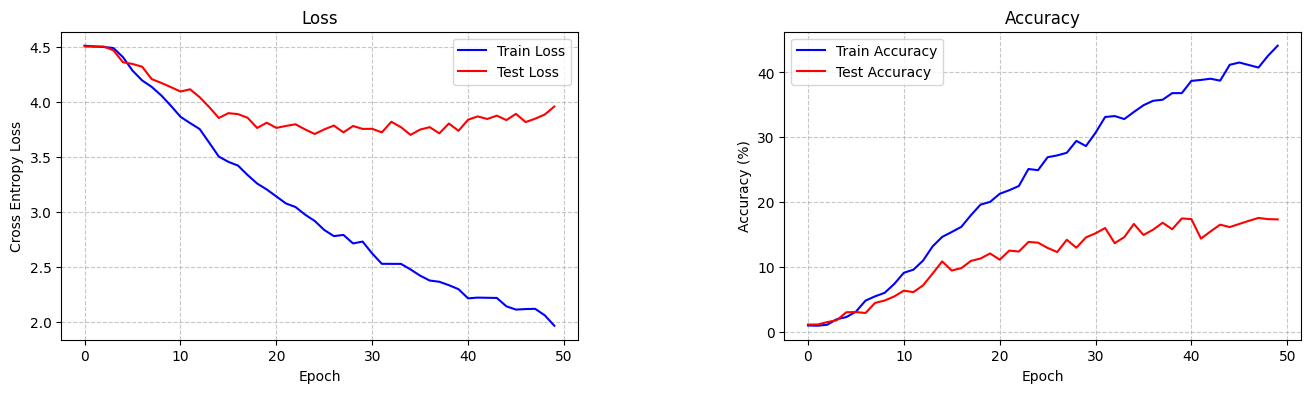

In [158]:
plot_loss_accuracy(result_cnn_100real_100ai)

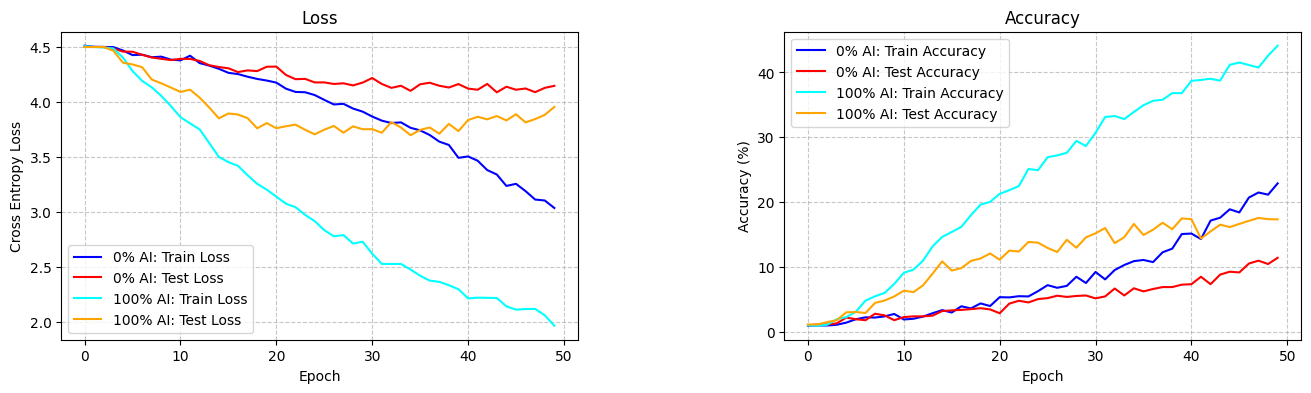

In [18]:
plot_loss_accuracy_diff(
    result_cnn_100real_0ai,
    result_cnn_100real_100ai,
    "0% AI: ",
    "100% AI: ",
)

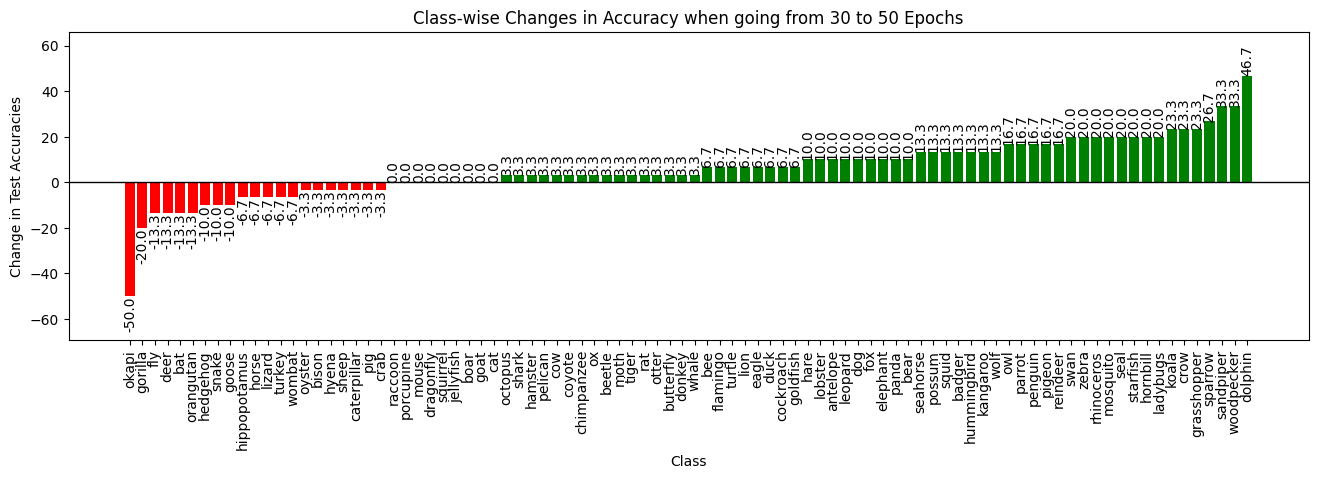

In [159]:
plot_improvement_by_class(result_cnn_100real_0ai, result_cnn_100real_100ai, "test_accuracies", CLASS_NAMES, "Class-wise Changes in Accuracy when going from 30 to 50 Epochs", 100.0)

In [162]:
plot_diff_table({
    "CNN: 100% real, 0% ai": result_cnn_100real_0ai,
    "CNN: 100% real, 50% ai": result_cnn_100real_50ai,
    "CNN: 100% real, 100% ai": result_cnn_100real_100ai,
    "CNN: 50% real, 100% ai": result_cnn_50real_100ai,
    "CNN: 0% real, 100% ai": result_cnn_0real_100ai,
}, "Comparison of Results by Metric for the CNN Model", DIFF_METRICS)

╭─────────────────────────┬──────────────────┬─────────────────┬──────────────────┬───────────────┬─────────────────╮
│                         │ Train Accuracy   │ Test Accuracy   │ Test Precision   │ Test Recall   │ Test F1 Score   │
├─────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ CNN: 100% real, 0% ai   │ 22.8889%         │ 11.4074%        │ 14.6854%         │ 11.4074%      │ 10.7273%        │
├─────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ CNN: 100% real, 50% ai  │ 33.3333%         │ 13.3333%        │ 18.9224%         │ 13.3333%      │ 13.1499%        │
├─────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ CNN: 100% real, 100% ai │ 44.1296%         │ 17.3333%        │ 20.8278%         │ 17.3333%      │ 17.2135%        │
├─────────────────────────┼──────────────────┼──────────

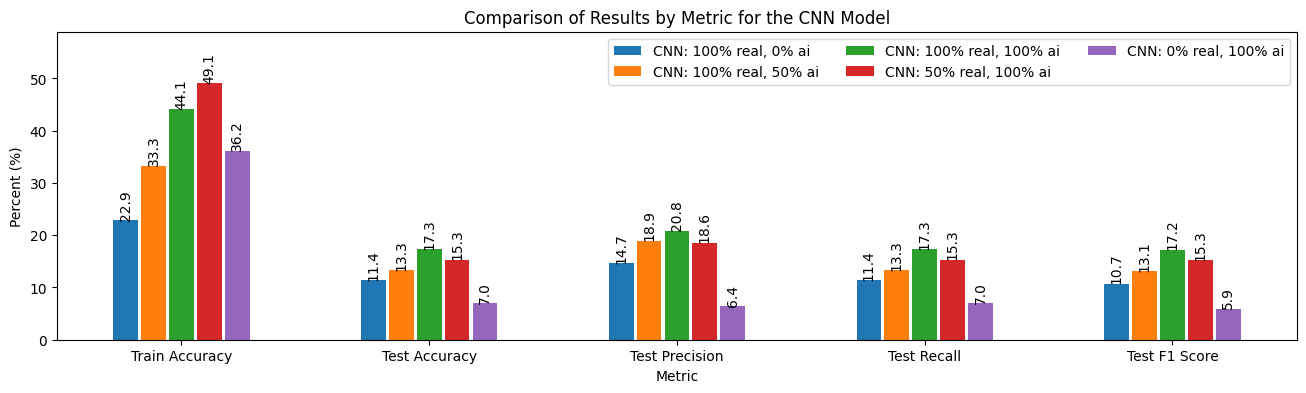

In [165]:
plot_diff_barchart({
    "CNN: 100% real, 0% ai": result_cnn_100real_0ai,
    "CNN: 100% real, 50% ai": result_cnn_100real_50ai,
    "CNN: 100% real, 100% ai": result_cnn_100real_100ai,
    "CNN: 50% real, 100% ai": result_cnn_50real_100ai,
    "CNN: 0% real, 100% ai": result_cnn_0real_100ai,
}, "Comparison of Results by Metric for the CNN Model", DIFF_METRICS)

In [168]:
plot_diff_table({
    "Combined: 100% real, 0% ai": result_combined_100real_0ai,
    "Combined: 100% real, 50% ai": result_combined_100real_50ai,
    "Combined: 100% real, 100% ai": result_combined_100real_100ai,
    "Combined: 50% real, 100% ai": result_combined_50real_100ai,
    "Combined: 0% real, 100% ai": result_combined_0real_100ai,
}, "Comparison of Results by Metric for the Combined Pre-trained Model", DIFF_METRICS)

╭──────────────────────────────┬──────────────────┬─────────────────┬──────────────────┬───────────────┬─────────────────╮
│                              │ Train Accuracy   │ Test Accuracy   │ Test Precision   │ Test Recall   │ Test F1 Score   │
├──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ Combined: 100% real, 0% ai   │ 99.7778%         │ 85.4815%        │ 85.9232%         │ 85.4815%      │ 85.4437%        │
├──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ Combined: 100% real, 50% ai  │ 99.8025%         │ 86.2963%        │ 86.9619%         │ 86.2963%      │ 86.3519%        │
├──────────────────────────────┼──────────────────┼─────────────────┼──────────────────┼───────────────┼─────────────────┤
│ Combined: 100% real, 100% ai │ 99.8333%         │ 85.5556%        │ 86.3633%         │ 85.5556%      │ 85.5986%        │
├───────────────

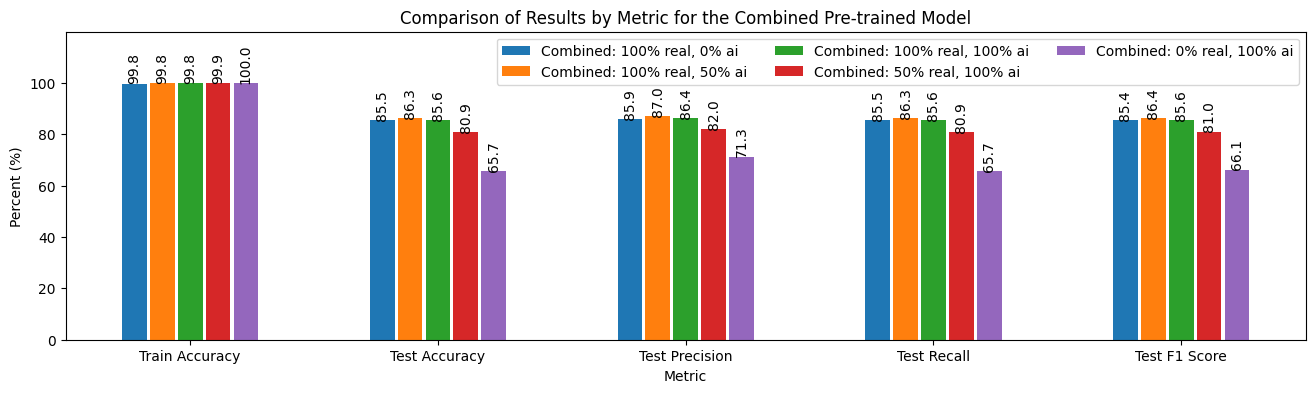

In [169]:
plot_diff_barchart({
    "Combined: 100% real, 0% ai": result_combined_100real_0ai,
    "Combined: 100% real, 50% ai": result_combined_100real_50ai,
    "Combined: 100% real, 100% ai": result_combined_100real_100ai,
    "Combined: 50% real, 100% ai": result_combined_50real_100ai,
    "Combined: 0% real, 100% ai": result_combined_0real_100ai,
}, "Comparison of Results by Metric for the Combined Pre-trained Model", DIFF_METRICS)